<a href="https://colab.research.google.com/github/ShubhamPrakash108/DogVsCat_Classifier/blob/main/DogVSCat_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Downloading the dataset

In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d razinw/dog-vs-cat

Dataset URL: https://www.kaggle.com/datasets/razinw/dog-vs-cat
License(s): unknown
 99% 409M/412M [00:15<00:00, 27.4MB/s]
100% 412M/412M [00:15<00:00, 27.3MB/s]


#Imports

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.image as mpimg
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import zipfile
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing import image

##Unzipping the dataset

In [ ]:
zip_file_path = '/content/dog-vs-cat.zip'

extract_dir = 'data'

os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f'Files extracted to {extract_dir}')


Files extracted to data


#Inspecting the folders

In [ ]:
for dirpath, dirnames, filenames in os.walk("/content/data"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 1 directories and 0 images in '/content/data'.
There are 2 directories and 0 images in '/content/data/dogvscat'.
There are 2 directories and 0 images in '/content/data/dogvscat/train'.
There are 0 directories and 250 images in '/content/data/dogvscat/train/0'.
There are 0 directories and 250 images in '/content/data/dogvscat/train/1'.
There are 2 directories and 0 images in '/content/data/dogvscat/test'.
There are 0 directories and 25 images in '/content/data/dogvscat/test/0'.
There are 0 directories and 25 images in '/content/data/dogvscat/test/1'.


#Viewing the random image from the dataset folder

In [ ]:
def view_random_image(target_dir, target_class):
  target_folder = target_dir+target_class
  random_image = random.sample(os.listdir(target_folder), 1)
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");
  print(f"Image shape: {img.shape}")

Image shape: (1000, 1000, 3)


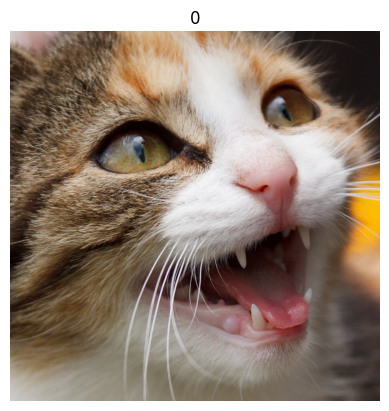

In [ ]:
view_random_image(target_dir="/content/data/dogvscat/train/",
                 target_class="0")

Image shape: (1000, 1000, 3)


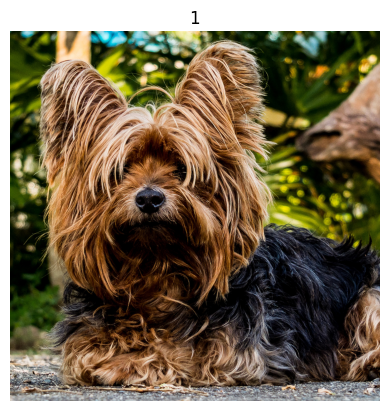

In [ ]:
view_random_image(target_dir="/content/data/dogvscat/train/",
                 target_class="1")

#Image preprocessing

In [ ]:
 #converting the image in between 0 and 1
tf.random.set_seed(42)

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
valid_datagen = ImageDataGenerator(rescale=1./255)

train_dir = "/content/data/dogvscat/train/"
test_dir = "/content/data/dogvscat/test/"


In [ ]:
#Creating train and test data generators

train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32,
                                               target_size=(512, 512),
                                               class_mode="binary",
                                               seed=42)

valid_data = valid_datagen.flow_from_directory(test_dir,
                                               batch_size=32,
                                               target_size=(512, 512),
                                               class_mode="binary",
                                               seed=42)

Found 500 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


#Modeling and Experimentation

##Model 1

In [29]:
model_1 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=10,
                         kernel_size=2,
                         activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2,
                            padding="valid"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation="sigmoid")
])

model_1.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/5
16/16 [==============================] - 47s 3s/step - loss: 0.8474 - accuracy: 0.5120 - val_loss: 0.6846 - val_accuracy: 0.5400
Epoch 2/5
16/16 [==============================] - 40s 2s/step - loss: 0.6901 - accuracy: 0.5160 - val_loss: 0.6907 - val_accuracy: 0.5000
Epoch 3/5
16/16 [==============================] - 39s 2s/step - loss: 0.6743 - accuracy: 0.5520 - val_loss: 0.7576 - val_accuracy: 0.4800
Epoch 4/5
16/16 [==============================] - 39s 2s/step - loss: 0.6793 - accuracy: 0.5780 - val_loss: 0.7124 - val_accuracy: 0.4800
Epoch 5/5
16/16 [==============================] - 39s 2s/step - loss: 0.6906 - accuracy: 0.5380 - val_loss: 0.6877 - val_accuracy: 0.5200


Bad result! Let's try transfer learning

Using DenseNet121...

#Model 2

In [ ]:
#importing the model
from tensorflow.keras.applications import InceptionV3

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model_2 = Model(inputs=base_model.input, outputs=predictions)

87910968/87910968 [==============================] - 3s 0us/step


In [ ]:
# Freeze all layers of the base model
for layer in base_model.layers:
    layer.trainable = False
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
model_2.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/5
16/16 [==============================] - 63s 3s/step - loss: 0.2869 - accuracy: 0.8880 - val_loss: 0.0307 - val_accuracy: 1.0000
Epoch 2/5
16/16 [==============================] - 41s 3s/step - loss: 0.0338 - accuracy: 0.9920 - val_loss: 0.0085 - val_accuracy: 1.0000
Epoch 3/5
16/16 [==============================] - 40s 3s/step - loss: 0.0109 - accuracy: 0.9960 - val_loss: 0.0042 - val_accuracy: 1.0000
Epoch 4/5
16/16 [==============================] - 42s 3s/step - loss: 0.0079 - accuracy: 1.0000 - val_loss: 0.0037 - val_accuracy: 1.0000
Epoch 5/5
16/16 [==============================] - 42s 3s/step - loss: 0.0065 - accuracy: 1.0000 - val_loss: 0.0033 - val_accuracy: 1.0000


#Prediction of model on our own data

In [ ]:
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

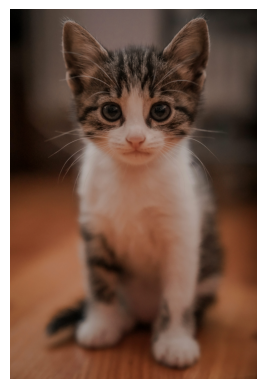

In [ ]:
img_path = '/content/catimage.jfif'
img = mpimg.imread(img_path)
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
img_array = load_and_preprocess_image(img_path)
predictions = model_2.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)
if predicted_class == 0:
    print('Cat')
else:
    print('Dog')

1/1 [==============================] - 0s 25ms/step
Cat
